In [74]:
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

# Localisation du fichier CSV
current_dir = Path().resolve()
project_root = current_dir.parent
data_path = project_root / "Data" / "Dataset of weighing station temperature measurements.csv"

# print("Fichier CSV :", data_path)

# IMPORTANT : le fichier est séparé par des ';'
df = pd.read_csv(data_path, sep=";")

# # Aperçu
# display(df.head())
# #print(df.columns)
# #print(df.max())
# temp_cols = [c for c in df.columns if "Low" in c or "Mid" in c or "Top" in c]
# max_temp = df[temp_cols].max().max()
# print(max_temp)


In [75]:
# On convertit la colonne Time en datetime et on la met en index
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time').sort_index()

# print(df.head())
# print(df.max())

In [76]:
# Colonnes de température à l'intérieur du puits
low_cols = [c for c in df.columns if "Low" in c]
mid_cols = [c for c in df.columns if "Mid" in c]
top_cols = [c for c in df.columns if "Top" in c]

# On les trie par numéro de capteur S1, S2, ... 
def sort_by_sensor(col_list):
    return sorted(col_list, key=lambda x: int(x.split("-S")[1]))

low_cols = sort_by_sensor(low_cols)
mid_cols = sort_by_sensor(mid_cols)
top_cols = sort_by_sensor(top_cols)

# P6 : données valides seulement à partir du 26 janvier 2024 
# date_debut_P6 = pd.to_datetime("2024-01-26")

# p6_sensors = [26, 27, 28, 29]

# p6_low_cols = [low_cols[s-1] for s in p6_sensors]
# p6_mid_cols = [mid_cols[s-1] for s in p6_sensors]
# p6_top_cols = [top_cols[s-1] for s in p6_sensors]

# p6_all_cols = p6_low_cols + p6_mid_cols + p6_top_cols

# # met à NaN toutes les valeurs de P6 avant le 26 janvier
# df.loc[df.index < date_debut_P6, p6_all_cols] = np.nan



print("Nb capteurs LOW :", len(low_cols))
print("Nb capteurs MID :", len(mid_cols))
print("Nb capteurs TOP :", len(top_cols))

print("\nExemples LOW :", low_cols[:5])
print("Exemples MID :", mid_cols[:5])
print("Exemples TOP :", top_cols[:5])


Nb capteurs LOW : 29
Nb capteurs MID : 29
Nb capteurs TOP : 29

Exemples LOW : ['T[degC]-Low-S1', 'T[degC]-Low-S2', 'T[degC]-Low-S3', 'T[degC]-Low-S4', 'T[degC]-Low-S5']
Exemples MID : ['T[degC]-Mid-S1', 'T[degC]-Mid-S2', 'T[degC]-Mid-S3', 'T[degC]-Mid-S4', 'T[degC]-Mid-S5']
Exemples TOP : ['T[degC]-Top-S1', 'T[degC]-Top-S2', 'T[degC]-Top-S3', 'T[degC]-Top-S4', 'T[degC]-Top-S5']


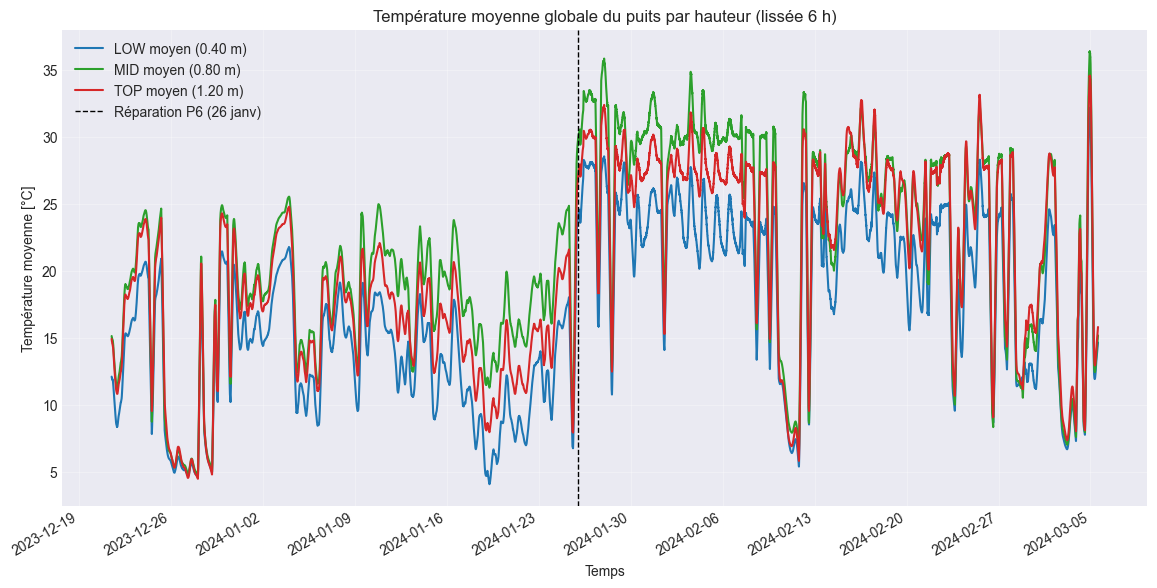

In [77]:
# moyenne globale sur tout le puits pour chaque hauteur
T_low_global = df[low_cols].mean(axis=1)
T_mid_global = df[mid_cols].mean(axis=1)
T_top_global = df[top_cols].mean(axis=1)

# Lissage sur 6 h 
T_low_smooth = T_low_global.rolling(window=180, center=True, min_periods=1).mean()
T_mid_smooth = T_mid_global.rolling(window=180, center=True, min_periods=1).mean()
T_top_smooth = T_top_global.rolling(window=180, center=True, min_periods=1).mean()

# Graphique : LOW/MID/TOP moyens (P1–P6)
plt.figure(figsize=(14, 7))
plt.plot(T_low_smooth.index, T_low_smooth, label="LOW moyen (0.40 m)", color="C0")
plt.plot(T_mid_smooth.index, T_mid_smooth, label="MID moyen (0.80 m)", color="C2")
plt.plot(T_top_smooth.index, T_top_smooth, label="TOP moyen (1.20 m)", color="C3")

# Ligne verticale pour la réparation
plt.axvline(pd.Timestamp("2024-01-26"), color="black", linestyle="--", linewidth=1, label="Réparation P6 (26 janv)")

plt.xlabel("Temps")
plt.ylabel("Température moyenne [°C]")
plt.title("Température moyenne globale du puits par hauteur (lissée 6 h)")
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.3)
plt.legend()
plt.show()

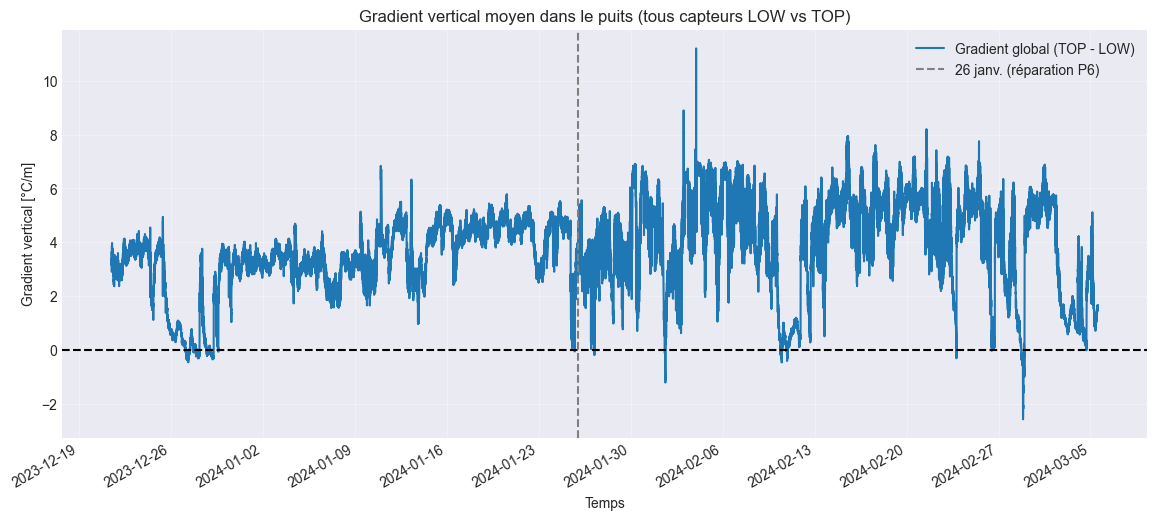

In [78]:
delta_z = 0.8  # m entre LOW (0.4 m) et TOP (1.2 m)

# Gradient vertical global (sur tout le puits)
dT_global = T_top_global - T_low_global    # [°C]
grad_global = dT_global / delta_z         # [°C/m]

plt.figure(figsize=(14, 6))

plt.plot(grad_global.index, grad_global, label="Gradient global (TOP - LOW)")

plt.axhline(0, linestyle="--", color="black")
plt.axvline(pd.Timestamp("2024-01-26"), color="grey", linestyle="--", label="26 janv. (réparation P6)")

plt.xlabel("Temps")
plt.ylabel("Gradient vertical [°C/m]")
plt.title("Gradient vertical moyen dans le puits (tous capteurs LOW vs TOP)")

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(alpha=0.3)
plt.legend()
plt.show()


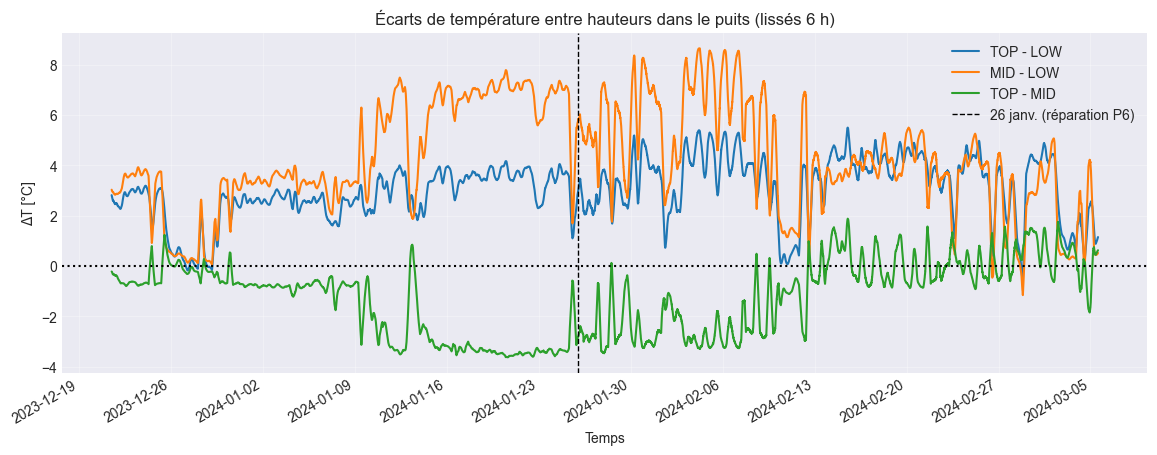

In [79]:
# Gradients verticaux globaux
dTOP_LOW = T_top_global - T_low_global
dMID_LOW = T_mid_global - T_low_global
dTOP_MID = T_top_global - T_mid_global

dTOP_LOW_s = dTOP_LOW.rolling(180, center=True, min_periods=1).mean()
dMID_LOW_s = dMID_LOW.rolling(180, center=True, min_periods=1).mean()
dTOP_MID_s = dTOP_MID.rolling(180, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 5))
plt.plot(dTOP_LOW_s.index, dTOP_LOW_s, label="TOP - LOW")
plt.plot(dMID_LOW_s.index, dMID_LOW_s, label="MID - LOW")
plt.plot(dTOP_MID_s.index, dTOP_MID_s, label="TOP - MID")
plt.axhline(0, color="k", linestyle=":")
plt.axvline(pd.Timestamp("2024-01-26"), color="black", linestyle="--", linewidth=1, label="26 janv. (réparation P6)")
plt.xlabel("Temps")
plt.ylabel("ΔT [°C]")
plt.title("Écarts de température entre hauteurs dans le puits (lissés 6 h)")
plt.legend()
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()



In [ ]:
# ΔT TOP-LOW par stand (S1...S29)

# dT_all : DataFrame avec une colonne par stand (S1, S2, ..., S29)
dT_all = pd.DataFrame(
    {
        f"S{i+1}": df[top_cols[i]] - df[low_cols[i]]   # ΔT = T_top - T_low
        for i in range(len(low_cols))
    },
    index=df.index,
)

# lisser ΔT pour ne pas compter le bruit
dT_all_smooth = dT_all.rolling("6H", center=True, min_periods=1).mean()


threshold = 2  # [°C] on considère qu'il y a stratification significative si TOP-LOW > x degrés celcius

# True si le stand i est stratifié au temps t
is_stratified = dT_all_smooth > threshold

# Fraction du temps où chaque stand est stratifié
frac_time_per_sensor = is_stratified.mean()

# Fraction du temps où au moins un stand est stratifié quelque part dans le puits
frac_time_any_sensor = is_stratified.any(axis=1).mean()

print("Fraction du temps où chaque stand est stratifié (ΔT TOP-LOW > 2°C) :")
print(frac_time_per_sensor)

print("\nFraction du temps où au moins un stand est stratifié dans le puits :",
      frac_time_any_sensor)



Fraction du temps où chaque stand est stratifié (ΔT TOP-LOW > 1.5°C) :
S1     0.119727
S2     0.856979
S3     0.888358
S4     0.728094
S5     0.000000
S6     0.786893
S7     0.448028
S8     0.000000
S9     0.655861
S10    0.819568
S11    0.880329
S12    0.825933
S13    0.212737
S14    0.559373
S15    0.300104
S16    0.628663
S17    0.463347
S18    0.456502
S19    0.909321
S20    0.000000
S21    0.895704
S22    0.856960
S23    0.005551
S24    0.128441
S25    0.000000
S26    0.219879
S27    0.222062
S28    0.077986
S29    0.201303
dtype: float64

Fraction du temps où au moins un stand est stratifié dans le puits : 0.9731534931912375


C:\Users\simon\AppData\Local\Temp\ipykernel_29456\1739325599.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dT_all_smooth = dT_all.rolling("6H", center=True, min_periods=1).mean()


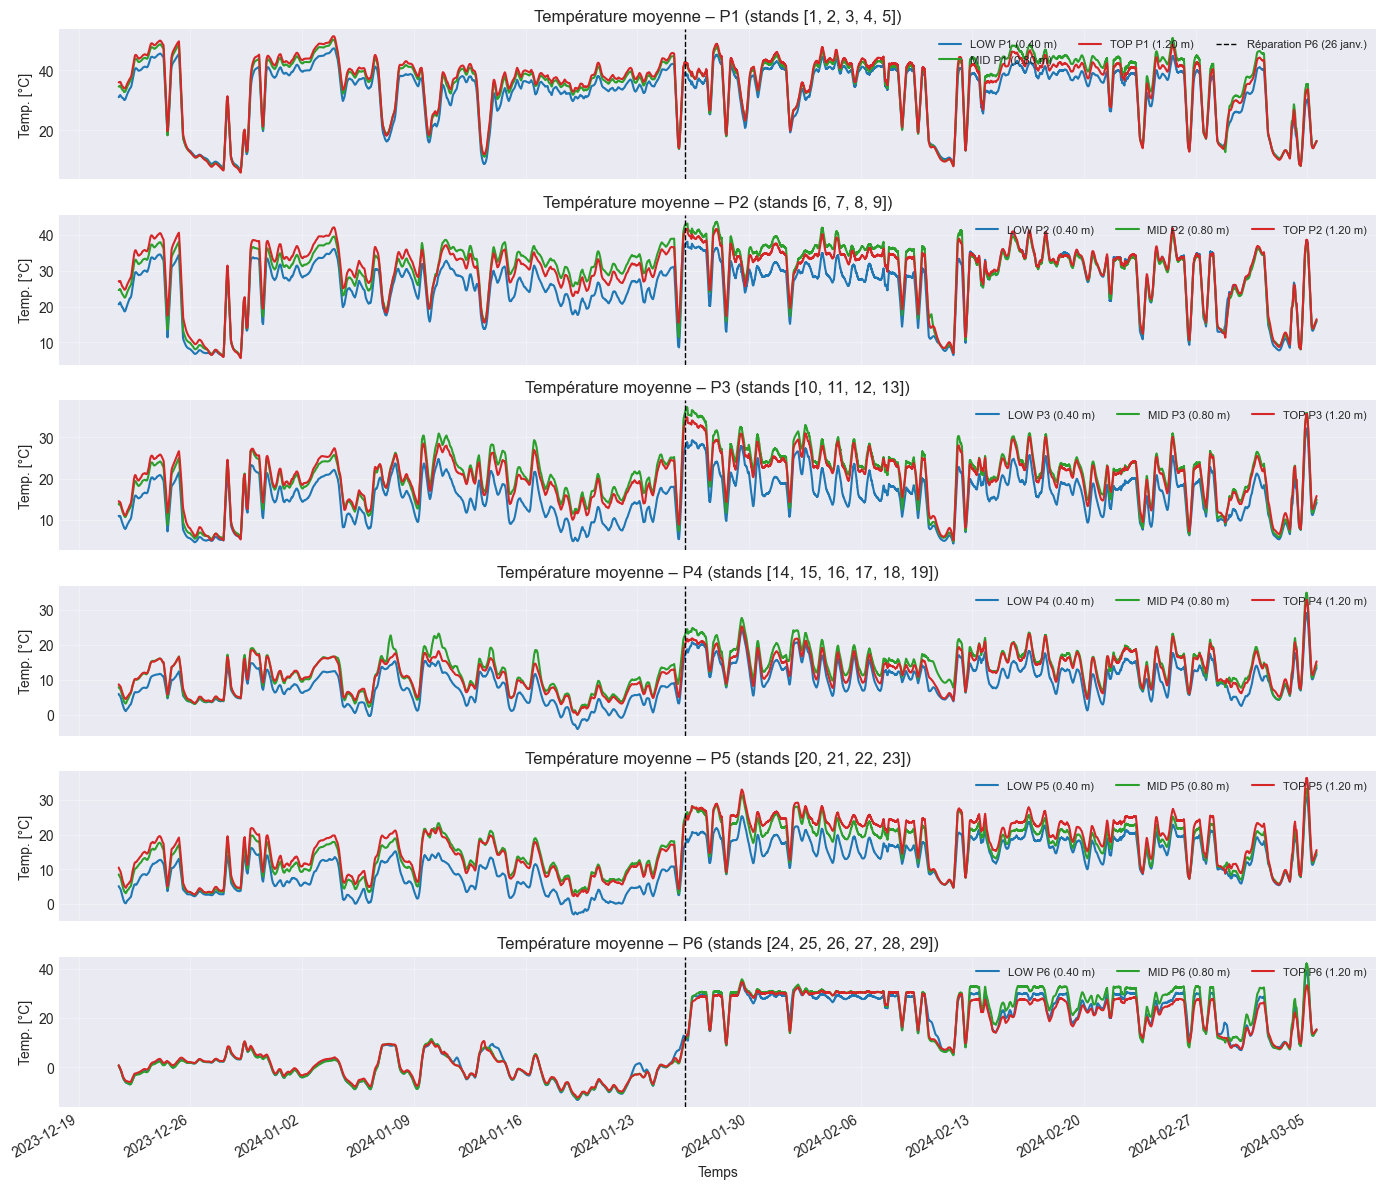

In [84]:

#Températures LOW / MID / TOP par zone (P1 à P6), lissées 6 h

zones_dict = {
    "P1": [1, 2, 3, 4, 5],
    "P2": [6, 7, 8, 9],
    "P3": [10, 11, 12, 13],
    "P4": [14, 15, 16, 17, 18, 19],
    "P5": [20, 21, 22, 23],
    "P6": [24, 25, 26, 27, 28, 29],
}

def zone_levels_smooth(df, sensors):
    """LOW/MID/TOP moyens sur la zone, lissés 6 h (comme le code global)."""
    T_low = df[[low_cols[s-1] for s in sensors]].mean(axis=1)
    T_mid = df[[mid_cols[s-1] for s in sensors]].mean(axis=1)
    T_top = df[[top_cols[s-1] for s in sensors]].mean(axis=1)

    T_low_s = T_low.rolling(window=180, center=True, min_periods=1).mean()
    T_mid_s = T_mid.rolling(window=180, center=True, min_periods=1).mean()
    T_top_s = T_top.rolling(window=180, center=True, min_periods=1).mean()
    return T_low_s, T_mid_s, T_top_s

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14, 12), sharex=True)

for ax, (zone, sensors) in zip(axes, zones_dict.items()):
    T_low_z, T_mid_z, T_top_z = zone_levels_smooth(df, sensors)

    ax.plot(T_low_z.index, T_low_z, label=f"LOW {zone} (0.40 m)", color="C0")
    ax.plot(T_mid_z.index, T_mid_z, label=f"MID {zone} (0.80 m)", color="C2")
    ax.plot(T_top_z.index, T_top_z, label=f"TOP {zone} (1.20 m)", color="C3")

    ax.axvline(pd.Timestamp("2024-01-26"), color="black", linestyle="--", linewidth=1,
               label="Réparation P6 (26 janv.)" if zone == "P1" else None)

    ax.set_ylabel("Temp. [°C]")
    ax.set_title(f"Température moyenne – {zone} (stands {sensors})")
    ax.grid(alpha=0.3)
    ax.legend(ncol=3, fontsize=8, loc="upper right")

# Axe X en dates (en bas seulement)
axes[-1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[-1].set_xlabel("Temps")
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


In [82]:
# # Capteurs de la zone P2
# sensors_P2 = [6, 7, 8, 9]

# # Température MID moyenne de la zone P2 (sur tout l’historique)
# T_mid_P2 = df[[mid_cols[s-1] for s in sensors_P2]].mean(axis=1)

# # Filtre entre le 10 et le 13 février 2024 (inclus)
# T_mid_P2_10_13 = T_mid_P2.loc["2024-02-10":"2024-02-13"]

# with pd.option_context("display.max_rows", None):
#     print(T_mid_P2_10_13)

Les mesures de température dans le puits (29 poteaux, 3 niveaux LOW/MID/TOP, zones P1 à P6) montrent une stratification verticale nette pendant tout l’hiver. 
En moyenne sur l’ensemble des zones, le niveau LOW est toujours le plus froid, alors que MID et TOP sont plus chauds, avec souvent MID légèrement au-dessus de TOP. 

Cela s’explique par le fait que les aérothermes injectent l’air chaud à une hauteur intermédiaire (près des capteurs MID), tandis que le haut du puits, proche de la dalle et des fuites d’air extérieur, subit davantage de pertes de chaleur.
Le gradient vertical global entre LOW et TOP est en moyenne d’environ 4 °C/m, ce qui correspond à un écart typique de 3 à 4 °C entre le bas (0,40 m) et le haut (1,20 m) du puits. 

Certains poteaux atteignent des gradients moyens de l’ordre de 8–9 °C/m (zones très stratifiées), alors que d’autres présentent des gradients plus faibles ou occasionnellement négatifs (zones plus mélangées ou refroidies localement). 

Enfin, la fraction du temps où au moins un poteau est stratifié est proche de 99 %, ce qui signifie qu’il existe pratiquement en tout temps une stratification verticale significative quelque part dans le puits, avec un comportement particulier pour la zone P6 avant le 26 janvier, période où ses données ont été exclues car le chauffage était défectueux.


In [83]:

def temperature_moyenne_poteau(df, sensor_id):
    col_low = low_cols[sensor_id - 1]
    col_mid = mid_cols[sensor_id - 1]
    col_top = top_cols[sensor_id - 1]
    
    # Moyenne en hauteur (LOW, MID, TOP) pour ce poteau
    T_poteau = df[[col_low, col_mid, col_top]].mean(axis=1)
    return T_poteau

poteaux = [1, 29]
T_moy = {}

for sid in poteaux:
    T_moy[sid] = temperature_moyenne_poteau(df, sid)
    T_moy_global = T_moy[sid].mean()
    print(f"Température moyenne poteau S{sid} : {T_moy_global:.2f} °C")


Température moyenne poteau S1 : 33.40 °C
Température moyenne poteau S29 : 13.23 °C
